In [9]:
PROCESSES_COUNT = 30

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, endf_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 1945 result folders
Loading data with 30 processes...


100%|██████████| 1945/1945 [00:33<00:00, 58.81it/s]


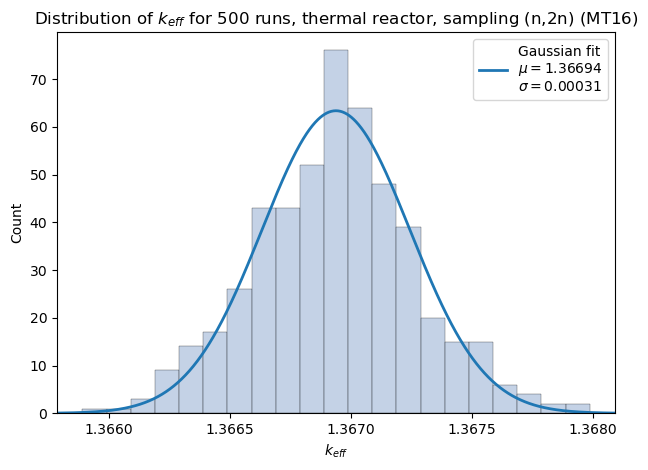

In [10]:
importlib.reload(plot_tools)

# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
USE_SAMPLED_DATA = True
MT = 16

# for FAST_REACTOR in [True, False]:
#     for USE_SAMPLED_DATA in [True, False]:

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{NEUTRON_TEMP}-{SAMPLED_STRING}-MT{MT}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}-{SAMPLED_STRING}-MT{MT}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]
df = df[df["MT"] == MT]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor, sampling {endf_tools.MT_to_label(MT, True)} (MT{MT})", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [17]:
importlib.reload(plot_tools)
importlib.reload(data_tools)

# Create a dataframe from the results
df = pd.DataFrame(results)

# FAST_REACTOR = False # True if epithermal, False if thermal
# MT = 2

# Create a dataframe to save the TMC results
tmc_df = pd.DataFrame()

# TMC analysis
for FAST_REACTOR in [False, True]:
    for MT in [2, 16, 22, 28, 51, 52, 102, 103, 104, 105, 107]:
        
        tmc_v1_res = data_tools.perform_TMC_v1(df, FAST_REACTOR, MT=MT, print_output=False, expected_N_ITERATIONS=500)
        if tmc_v1_res is None: # No results found, continue
            continue 
        
        df_dictionary = pd.DataFrame([tmc_v1_res])
        tmc_df = pd.concat([tmc_df, df_dictionary], ignore_index=True)

tmc_df.head()

# print("")
# tmc_v1_res = data_tools.perform_TMC_v1(df, FAST_REACTOR=True, MT=16, print_output=True, expected_N_ITERATIONS=500)

No data for THERMAL, (n,na) (MT22)
No data for THERMAL, (n,np) (MT28)
No data for THERMAL, (n,n1) (MT51)
No data for THERMAL, (n,n2) (MT52)
No data for THERMAL, (n,$\gamma$) (MT102)
No data for THERMAL, (n,p) (MT103)
No data for THERMAL, (n,d) (MT104)
No data for THERMAL, (n,t) (MT105)
No data for THERMAL, (n,a) (MT107)
No data for EPITHERMAL, (n,na) (MT22)
No data for EPITHERMAL, (n,np) (MT28)
No data for EPITHERMAL, (n,n1) (MT51)
No data for EPITHERMAL, (n,n2) (MT52)
No data for EPITHERMAL, (n,$\gamma$) (MT102)
No data for EPITHERMAL, (n,p) (MT103)
No data for EPITHERMAL, (n,d) (MT104)
No data for EPITHERMAL, (n,t) (MT105)
No data for EPITHERMAL, (n,a) (MT107)


,sigma_obs,sigma2_obs,sigma_stat_mean,sigma2_stat_mean,sigma_ND,sigma2_ND,k_eff_mean,R_obs,R_stat_mean,R_ND,u_k,u_rho,N_ITERATIONS,fast_reactor,MT
0,0.000620,3.843546e-07,0.000315,9.938319e-08,0.000534,2.849714e-07,1.366908,0.000454,0.000231,0.000391,1.3669+/-0.0005,0.26842+/-0.00029,500,False,2
1,0.000332,1.101153e-07,0.000315,9.948214e-08,0.000103,1.063319e-08,1.366936,0.000243,0.000231,0.000075,1.36694+/-0.00010,0.26844+/-0.00006,500,False,16
2,0.001504,2.262456e-06,0.000299,8.936894e-08,0.001474,2.173087e-06,0.972773,0.001546,0.000307,0.001515,0.9728+/-0.0015,-0.0280+/-0.0016,500,True,2
3,0.000338,1.139160e-07,0.000299,8.914726e-08,0.000157,2.476878e-08,0.972794,0.000347,0.000307,0.000162,0.97279+/-0.00016,-0.02797+/-0.00017,445,True,16


In [4]:
raise Exception("STOP") # Not doing v2 analysis for R11
# # 26 feb 2023 - correct TMC analysis
# importlib.reload(plot_tools)

# # TMC analysis

# FAST_REACTOR = False # True if epithermal, False if thermal

# NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]
# df = df[df["use_sampled_data"] == True]

# plt.figure()
# fig_sampled, popt_sampled, pcov_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == True], data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")

# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]
# df = df[df["use_sampled_data"] == False]

# plt.figure()
# fig_not_sampled, popt_not_sampled, pcov_not_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == False], data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")



# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]

# plt.figure()
# fig_combined, popts_combined, pcovs_combined = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for $n={len(df)//2}$ runs, {NEUTRON_TEMP.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
#                                         hue="use_sampled_data", hue_order=[1,0], hue_labels=["Sampled", "Not sampled"],
#                                         filename=f"combined_{NEUTRON_TEMP}.pdf")

# σ_sampled = np.abs(popts_combined[1][2])
# σ_not_sampled = np.abs(popts_combined[0][2])
# σ_ND = np.sqrt(σ_sampled**2 - σ_not_sampled**2)
# k_eff_mean = np.mean(df["k-eff"])
# R_sampled = σ_sampled / k_eff_mean
# R_not_sampled = σ_not_sampled / k_eff_mean
# R_ND = σ_ND / k_eff_mean

# u_k = ufloat(k_eff_mean, σ_ND)
# u_rho = 1 - 1/u_k

# print("TMC analysis v2")
# print("===============")
# print(f"{NEUTRON_TEMP}")
# print(f"Based on {len(df)} runs")
# print(f" -- k_eff --")
# print(f"k_eff: \t\t{k_eff_mean:.3f}")
# print(f"σ_sampled: \t{σ_sampled:.2e}")
# print(f"σ_not_sampled: \t{σ_not_sampled:.2e}")
# print(f"σ_ND: \t\t{σ_ND:.2e}")
# print(f"R_sampled: \t{(R_sampled*1e5):.1f} pcm")
# print(f"R_not_sampled: \t{(R_not_sampled*1e5):.1f} pcm")
# print(f"R_ND: \t\t{(R_ND*1e5):.1f} pcm")
# print(f" -- ρ --")
# print(f"ρ: \t\t{(u_rho.nominal_value*1e5):.1f} pcm")
# print(f"ρ-std: \t\t{(u_rho.std_dev*1e5):.1f} pcm")


Exception: STOP